# Chronos-2 Foundation Model Fine-Tuning
This example notebook presents how fine-tuning can be applied to the Chronos-2 model.

The following fine-tuning methods will be shown:
1) Full fine-tuning : all the models weights will be retrained
2) Partial fine-tuning : some layers of the model will be frozen
3) PEFT fine-tuning : the HuggingFace peft library will be used to apply LoRA fine-tuning (requires `pip install peft` since it is not a darts dependency)

To be useful, a fine-tuned model should be easily saved and loaded. For each fine-tuning method, how to save and load the model will be shown with an example (straightforward for (1) and (2), slightly different for (3))

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [3]:
import warnings

import numpy as np

from darts.datasets import AirPassengersDataset
from darts.models import Chronos2Model

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

## Data Preparation
Here we just load an example dataset with 144 samples as a fast demo. The data is split between train and validation, with the 2 last years (24 samples) for validation

In [4]:
# convert to float32 as Chronos-2 works with float32 input
data = AirPassengersDataset().load().astype(np.float32)
train_passengers, val_passengers = data.split_before(
    len(data) - 2 * 12
)  # last 2 years for validation

# Model prediction out-of-the-box
Let's see how the model behaves on the validation data without any fine-tuning. For that we:
- Create the model
- Call fit to load the model internally (no training is done)
- Predict on the validation set

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Base model (not finetuned yet)'}, xlabel='Month'>

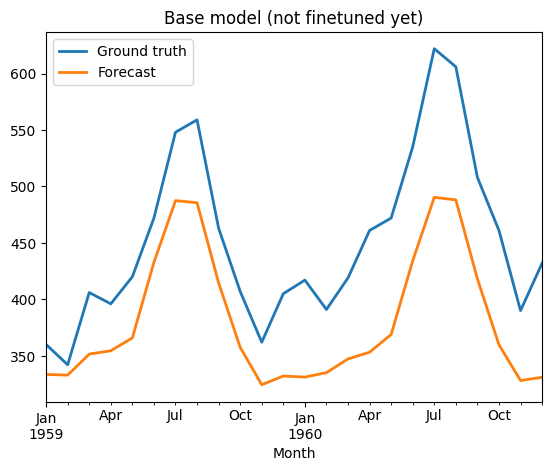

In [5]:
model = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
)
model.fit(train_passengers, verbose=True)

prediction = model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="Ground truth")
prediction.plot(label="Forecast", title="Base model (not finetuned yet)")

# 1. Full fine-tuning

In this method, all the model weights are retrained. This is done with `enable_finetuning=True` in the model constructor.

The model is saved and loaded with the usual `save` and `load` methods, so the behavior is the same as other darts models.

In [6]:
full_finetuned_model = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu"},
)
full_finetuned_model.fit(train_passengers, verbose=True)
full_finetuned_model.save("full_finetuned.pt")

# Load
full_finetuned_loaded_model = Chronos2Model.load("full_finetuned.pt")

Training: |          | 0/? [00:00<?, ?it/s]

We can compare the prediction with the ground truth, as well as checking that the loaded model behaves similarly to the fine-tuned model.

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Full finetuning'}, xlabel='Month'>

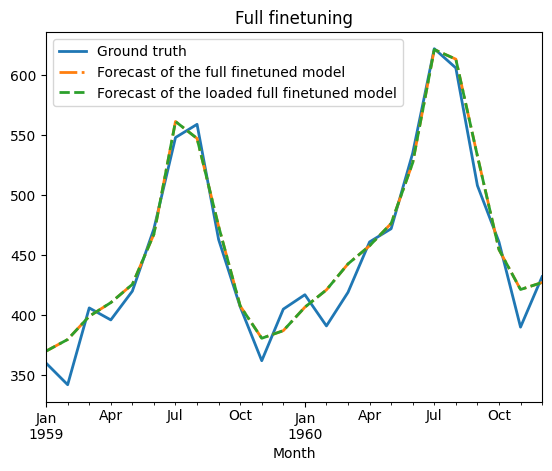

In [7]:
pred_full_finetuned = full_finetuned_model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
pred_full_finetuned_loaded = full_finetuned_loaded_model.predict(
    n=len(val_passengers),
    series=train_passengers,
)
val_passengers.plot(label="Ground truth")
pred_full_finetuned.plot(label="Forecast of the full finetuned model", linestyle="-.")
pred_full_finetuned_loaded.plot(
    label="Forecast of the loaded full finetuned model",
    linestyle="--",
    title="Full finetuning",
)

We can also verify numericaly that the prediction of the trained model is identical to the prediction of the loaded model

In [8]:
np.allclose(pred_full_finetuned.values(), pred_full_finetuned_loaded.values())

True

# 2. Partial fine-tuning with layer freezing
With this method, top layers of the model will be frozen. That means that their weights won't be updated during the fine-tuning. 

In [6]:
partial_finetuned_model = Chronos2Model(
    input_chunk_length=12,
    output_chunk_length=6,
    enable_finetuning=True,
    freeze_patterns=["encoder.block.0", "encoder.block.1", "encoder.block.2"],
    unfreeze_patterns=["output_patch_embedding"],
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu"},
)
partial_finetuned_model.fit(train_passengers, verbose=True)
partial_finetuned_model.save("partial_finetuned.pt")

# Load - no callback needed, structure unchanged
partial_finetuned_loaded_model = Chronos2Model.load("partial_finetuned.pt")

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'Partial finetuning'}, xlabel='Month'>

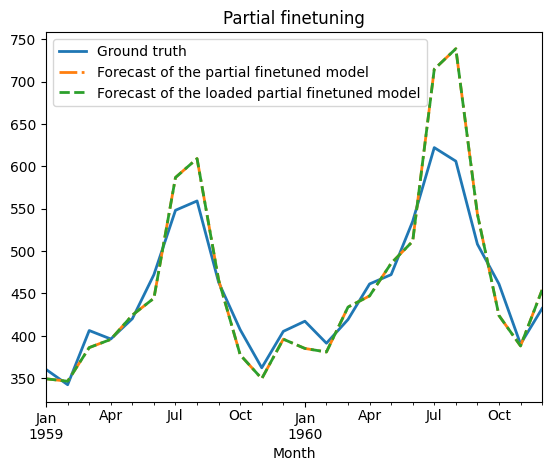

In [7]:
pred_partial_finetuned = partial_finetuned_model.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_partial_finetuned_loaded = partial_finetuned_loaded_model.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_partial_finetuned.plot(
    label="Forecast of the partial finetuned model", linestyle="-."
)
pred_partial_finetuned_loaded.plot(
    label="Forecast of the loaded partial finetuned model",
    linestyle="--",
    title="Partial finetuning",
)

Again, we verify that the prediction of the fine-tuned model is the same as the loaded model to make sure that saving/load works correctly

In [11]:
np.allclose(pred_partial_finetuned.values(), pred_partial_finetuned_loaded.values())

True

# 3. LoRA fine-tuning
This fine-tuning method uses HuggingFace `peft` library. This library makes it easy to use **P**arameter **E**fficient **F**ine-**T**uning methods such as LoRA which greatly reduces the number of fine-tuned parameters.

More information about peft can be found in the [official documentation](https://github.com/huggingface/peft)

To use LoRA fine-tuning, the `PeftCallback` is used. A `peft_config` is required. In this example, a `LoraConfig` is used with the same parameters used in the [official Chronos-2 implementation](https://github.com/amazon-science/chronos-forecasting/blob/f889ae66477b53f6beb130f5c7b13590b29a1035/src/chronos/chronos2/pipeline.py#L202)


In [8]:
from peft import LoraConfig

from darts.utils.callbacks.fine_tuning import PeftCallback

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q",
        "v",
        "k",
        "o",
        "output_patch_embedding.output_layer",
    ],
)
peft_callback = PeftCallback(peft_config=lora_config)

model_lora = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
    enable_finetuning=True,
    n_epochs=100,
    pl_trainer_kwargs={"accelerator": "gpu", "callbacks": [peft_callback]},
)
model_lora.fit(train_passengers, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

Chronos2Model(output_chunk_shift=0, likelihood=None, hub_model_name=amazon/chronos-2, hub_model_revision=None, local_dir=None, input_chunk_length=24, output_chunk_length=6, enable_finetuning=True, n_epochs=50, pl_trainer_kwargs={'accelerator': 'gpu', 'callbacks': [<darts.utils.callbacks.fine_tuning.PeftCallback object at 0x000001DCDADB4200>]})

## 3.1 Full-model saving
Darts `save` and `load` methods can be used to save the full model weights.

In [9]:
# Fully save the model including adapters
model_lora.save("chronos2_lora_finetuned.pt")
model_lora_loaded = Chronos2Model.load("chronos2_lora_finetuned.pt")

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'LoRA finetuning - Save all'}, xlabel='Month'>

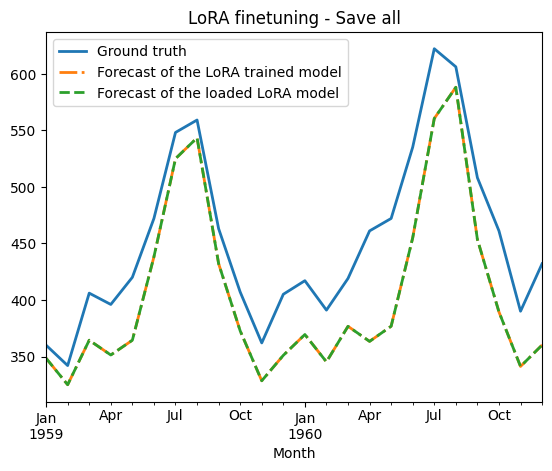

In [10]:
pred_lora_trained = model_lora.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_lora_loaded = model_lora_loaded.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_lora_trained.plot(label="Forecast of the LoRA trained model", linestyle="-.")
pred_lora_loaded.plot(
    label="Forecast of the loaded LoRA model",
    linestyle="--",
    title="LoRA finetuning - Save all",
)

Again, we verify that the prediction of the fine-tuned model is the same as the loaded model to make sure that saving/load works correctly

In [11]:
np.allclose(pred_lora_loaded.values(), pred_lora_trained.values())

True

## 3.2 Adapter saving
Another method is to save only the adapter. This results in a light-weight folder containing only the LoRA weights which can be plugged to the original model.

For that, we need to access the internal chronos model with the `internal_model` attribute to save only the adapter.

In [12]:
model_lora.internal_model.save_pretrained("chronos2_lora_adapters/")

Then, a new model can be created, and the internal model can be replaced with the loaded adapter

In [13]:
from peft import PeftModel

model_new = Chronos2Model(
    input_chunk_length=24,
    output_chunk_length=6,
)
model_new.fit(train_passengers)  # Initialize model

# Replace _Chronos2Module with PeftModel containing _Chronos2Module + adapters
model_new.internal_model = PeftModel.from_pretrained(
    model_new.internal_model, "chronos2_lora_adapters/"
)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: title={'center': 'LoRA finetuning - Save adapters only'}, xlabel='Month'>

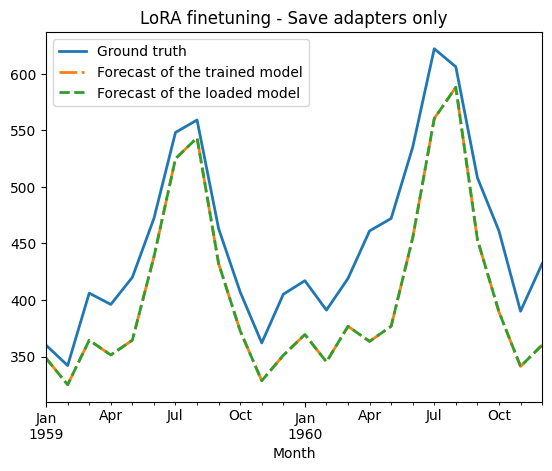

In [14]:
pred_lora_trained = model_lora.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
pred_new = model_new.predict(
    n=len(val_passengers),
    series=train_passengers,
    random_state=42,
)
val_passengers.plot(label="Ground truth")
pred_lora_trained.plot(label="Forecast of the trained model", linestyle="-.")
pred_new.plot(
    label="Forecast of the loaded model",
    linestyle="--",
    title="LoRA finetuning - Save adapters only",
)